In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import shapely
from matplotlib_scalebar.scalebar import ScaleBar
import os
import matplotlib as mpl
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

%load_ext autoreload
%autoreload 2

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/wsfish/glioblastoma/FISHspace/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
#adata = sc.read_h5ad('../../EEL_AnnData/EEL_41CleanNuclei-CellularNgh_FeaturesMN.h5ad')
adata = sc.read_h5ad('../GBM_Linnarsson_EEL.h5ad')
a = ['Endothelial' if x.count('Endothelial') else x for x in adata.obs['m-states']]
adata.obs['m-states'] = pd.Categorical(['Mural' if x.count('Mural') else x for x in a])
adata

AnnData object with n_obs × n_vars = 6139386 × 878
    obs: 'Area', 'CellID', 'Centroid', 'Polygons', 'Sample', 'X', 'Y', 'batch', 'ID', 'CellularNgh', 'm-states', 'm-states80', 'tumour_vs_astrocyte', 'm-states2'
    var: 'Accession', 'Gene'
    obsm: 'spatial'

In [23]:
rename_dic = {
    'GW-like 5':'GW-like Endo.Ass.',
    'GW-like 2':'GW-like Periphery1',
    'GW-like 3':'GW-like Periphery2',
    'GW-like 1':'GW-like Periphery3',
    
    'GW-like 6':'GW-like HYPR1',
    'GW-like HYPR1':'GW-like HYPR2',
    'GW-like 7':'GW-like OPC',
    'GW-like 4':'GW-like nIPC',
 
}

adata.obs['m-states3'] = pd.Categorical([rename_dic[m] if m in rename_dic else m for m in adata.obs['m-states2']])

In [24]:
adata.obs['m-states3'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'Astrocyte', 'DC', 'Endothelial 1',
       'Erythrocyte 1', 'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1',
       'GBL-like 2', 'GW-like Endo.Ass.', 'GW-like HYPR1', 'GW-like HYPR2',
       'GW-like OPC', 'GW-like Periphery1', 'GW-like Periphery2',
       'GW-like Periphery3', 'GW-like nIPC', 'Mono 1', 'Mono 2',
       'Mural cell 1', 'Mural cell 2', 'OPC-like 1', 'OPC-like 2',
       'Oligodendrocyte 1', 'Oligodendrocyte 2', 'RG-like', 'TAM-BDM 1',
       'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'nIPC-RG-like',
       'nIPC-like 1', 'nIPC-like 2', 'nIPC-like 3', 'preOPC-like 1',
       'unknown 1', 'unknown2 1'],
      dtype='object')

In [7]:
palette = {
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    
    
    'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'GW-like Periphery1': '#EDE8F3',
    'GW-like Periphery2': '#E2D8EA',
    'GW-like Periphery3': '#D6BEDD',
    'GW-like Endo.Ass.': '#CFA8D1',
    'GW-like nIPC': '#CA90C5',
    'GW-like OPC': '#D873B6',
    'GW-like HYPR1': '#C50F53',
    'GW-like HYPR2': '#840034',
        
    
    'nIPC-like 1':'#FFF192',
    'nIPC-like 2':'#FFF192',
    'nIPC-like 3':'#FFF192',

    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    'OPC-like 3':'#89c4f4', #bright turquoise
    'OPC-like':'#89c4f4',
    
    #'Endothelial':'#d5b8ff', #mauve
    'Endothelial 1':'#8c14fc',#'#d5b8ff', #mauve
    'Endothelial':'#8c14fc',#'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell 1': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    
    'Fibroblast': '#fbe7ef',
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
     #'FB-like 1': '#FF6EC7', #fff9de

    'Mono 1': '#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-MDM 1':'#e88474',#'#F5C9B0',
    'TAM-MDM 2':'#A94A54',
    
    'TAM-MDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-MDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-BDM 1':'#e88474',#'#F5C9B0',
    'TAM-BDM 2':'#A94A54',
    
    'TAM-BDM 3':'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    'DC': '#a6915c',
}

palette_classes = {
    'GBL-like':'#c2f970',#'#c2f970'
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'preOPC-like':'#7befb2',#'#c2f970'

    #'GW-like': '#EDE8F3',
    'GW-like': '#C50F53',
    'NPC-like':'#FFF192',
    'RG':'#ff9470',
    
    'OPC-like':'#89c4f4',

    'FB-like': '#FF6EC7', #fff9de

}

In [8]:
adata.obs['m-states'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'DC', 'Endothelial', 'Erythrocyte 1',
       'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1', 'GBL-like 2',
       'GW-like 1', 'GW-like 2', 'GW-like 3', 'GW-like 4', 'GW-like 5',
       'GW-like 6', 'GW-like 7', 'GW-like 8', 'Mono 1', 'Mono 2', 'Mural',
       'OPC-like 1', 'OPC-like 2', 'Oligodendrocyte 1', 'Oligodendrocyte 2',
       'RG-like', 'TAM-BDM 1', 'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG',
       'nIPC-RG-like', 'nIPC-like 1', 'nIPC-like 2', 'nIPC-like 3',
       'preOPC-like 1', 'unknown 1', 'unknown2 1'],
      dtype='object')

2024-05-22 11:49:22,850 - INFO - First filter, 27384 cells left
2024-05-22 11:49:23,176 - INFO - Selecting cells in zoom area
2024-05-22 11:49:24,208 - INFO - Zoom filter, 7647 cells left


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


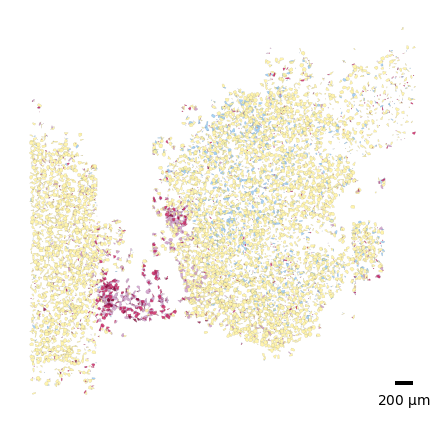

In [27]:
sp.pl.plot_polygons(
    adata,
    sample='SL034',
    palette=palette,
    #geometry_key='Centroid',
    cluster_key= 'm-states3',
    clusters = ['OPC-like 1','OPC-like 2', 'nIPC-like 3','GW-like nIPC','GW-like HYPR1', 'GW-like HYPR2'],
    markersize=.25,
    figsize=(5,5),
    area_min_size=0,
    xlim=(2500, 7000),
    ylim=(0,6000),

    show_scalebar=True,
    show_axis=False,
    save=True,
    savepath='figures/SL034.svg',
    
)

In [16]:
from FISHscale.utils.dataset import Dataset
from skimage import img_as_bool
from skimage.transform import rescale
import zarr

SL034 = Dataset('/wsfish/glioblastoma/EEL/Phase1/Analysis/JJEXP20220426_EEL_SL034_S1/JJEXP20220426_EEL_SL034_S1_RNA_transformed_assigned.parquet',
             gene_label='decoded_genes',
             pixel_size='0.27 micrometers',
             reparse=True,
            )

img = zarr.load('/datc/sl/fish_rawdata/JJEXP20220426_EEL_SL034_S1/fresh_tissue/segmentation/image_segmented_labels.zarr/segmented_labels_image/')
#img = np.flip(img, axis=0)
img[img >0] = 1
img_d = rescale(img, 0.27, anti_aliasing=False)
img_d[img_d >0] = 1
img_d = img_as_bool(img_d)
#x1, y1, x2, y2 = x1*0.27, y1*0.27, x2*0.27, y2*0.27

100%|████████████████████████████████████████████████████████████████████████| 890/890 [00:11<00:00, 78.95it/s]


2024-05-24 10:58:05,920 - INFO -     Loaded: JJEXP20220426_EEL_SL034_S1_RNA_transformed_assigned


In [17]:
img_SL034 = img_d

In [18]:
import matplotlib.colors as mcolors

In [19]:
gene_color={
    'SOX2':'#038aff',
    'SOX9':'#87d37c', 
    'FOXG1':'#93faa5',#'#963694', 
    'NOTCH1':'#af4154',
    'OLIG1': '#67f2d1',
    'OLIG2': '#67f2d1',
    'PDGFRA': '#ffff9f',
}

In [20]:
mcolors.rgb2hex(palette['GW-like HYPR1'])

'#c50f53'

<Axes: >

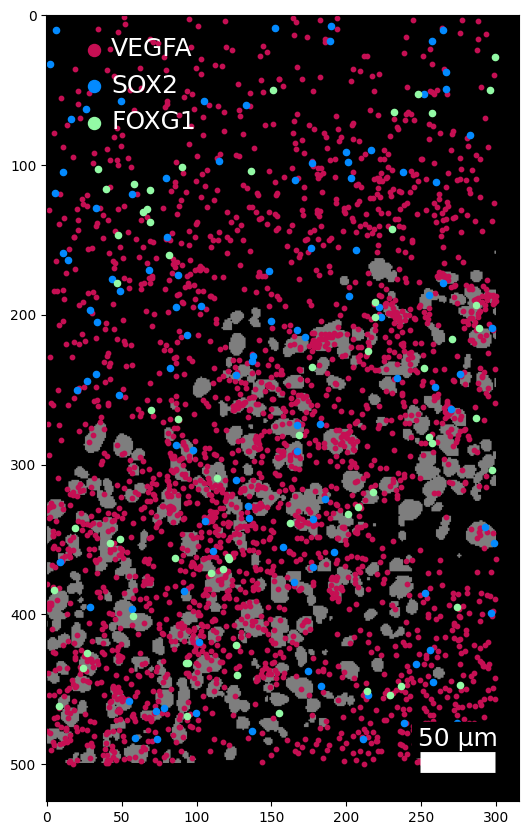

In [21]:
xlim=(3500, 3800)
ylim=(1500,2000)

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_SL034[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

SL034.color_dict['VEGFA'] = mcolors.rgb2hex(palette['GW-like HYPR1'])
SL034.color_dict['FOXG1'] = mcolors.rgb2hex(gene_color['FOXG1'])
SL034.color_dict['SOX9'] = mcolors.rgb2hex(gene_color['SOX9'])
SL034.color_dict['SOX2'] = mcolors.rgb2hex(gene_color['SOX2'])
SL034.color_dict['NOTCH1'] = mcolors.rgb2hex(gene_color['NOTCH1'])
SL034.color_dict['OLIG1'] = mcolors.rgb2hex(gene_color['OLIG1'])
SL034.color_dict['PDGFRA'] = mcolors.rgb2hex(gene_color['PDGFRA'])

sizes = [10, 20, 20] 
genes = ['VEGFA','SOX2','FOXG1']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

SL034.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=True,
    show_legend=True,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    alpha_img=.5,
    save=True,
    save_name='figures/SL034_dots.svg'
)

2024-05-22 11:48:35,142 - INFO - First filter, 30266 cells left
2024-05-22 11:48:35,436 - INFO - Selecting cells in zoom area
2024-05-22 11:48:36,241 - INFO - Zoom filter, 2525 cells left


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


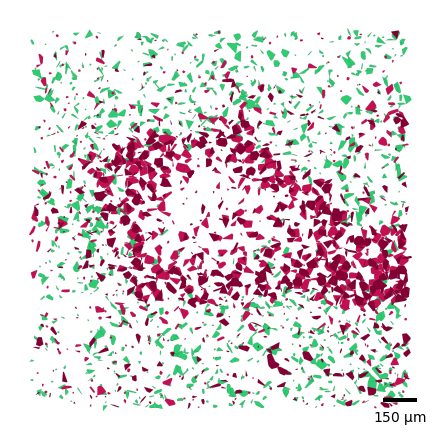

In [26]:
xlim = (7300,9000)
ylim=(2100,3800)
#xlim = (8300,9300)
#ylim = (4000,5000)

sp.pl.plot_polygons(
    adata,
    sample='SL046C',
    cluster_key='m-states3',
    clusters=['AC-like 3','AC-like 5','AC-like 6','GW-like HYPR1', 'GW-like HYPR2'],
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    palette= palette,
    figsize=(5,5),
    save=True,
)

In [2]:
from FISHscale.utils.dataset import Dataset
from skimage import img_as_bool
from skimage.transform import rescale
import zarr

SL046C = Dataset('/wsfish/glioblastoma/EEL/Phase1/Analysis/JJEXP20220505_EEL_SL046C_S2/JJEXP20220505_EEL_SL046C_S2_RNA_transformed_assigned.parquet',
             gene_label='decoded_genes',
             pixel_size='0.27 micrometers',
             reparse=True,
            )

img = zarr.load('/datc/sl/fish_rawdata/JJEXP20220505_EEL_SL046C_S2/fresh_tissue/segmentation/image_segmented_labels.zarr/segmented_labels_image/')
#img = np.flip(img, axis=0)
img[img >0] = 1
img_d = rescale(img, 0.27, anti_aliasing=False)
img_d[img_d >0] = 1
img_d = img_as_bool(img_d)
img_SL046C = img_d
#x1, y1, x2, y2 = x1*0.27, y1*0.27, x2*0.27, y2*0.27

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it

2024-05-24 09:26:01,155 - INFO -     Loaded: JJEXP20220505_EEL_SL046C_S2_RNA_transformed_assigned


<Axes: >

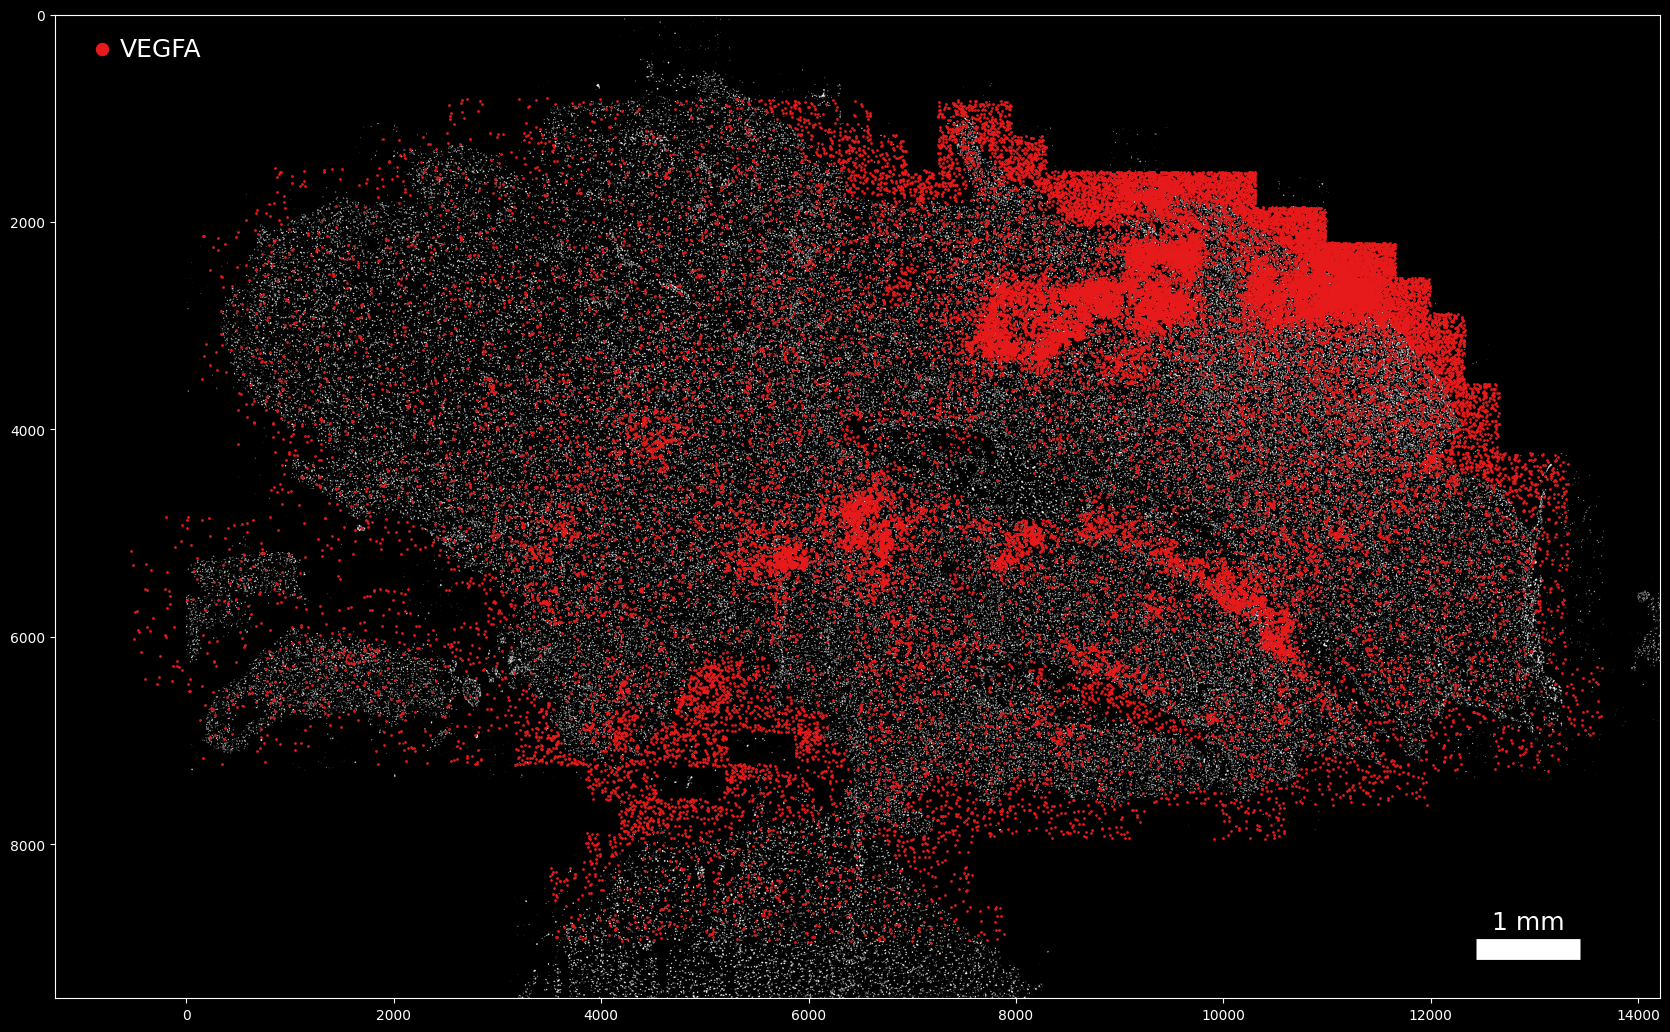

In [3]:
SL046C.color_dict['VEGFA'] = (0.9,0.1,0.1)
SL046C.scatter_plot(
    ['VEGFA'],
    s=[1],
    ax_scale_factor=50,
    show_axes=True,
    show_legend=True,
    image=img_d,
    reset_xy=True,
)

In [12]:
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

<Axes: >

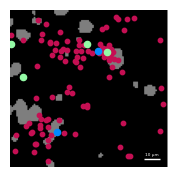

In [13]:
xlim=(7850, 7950)
ylim=(2650, 2750)

#xlim_rev = ()
#ylim_rev = ()

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_SL046C[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

sizes = [10, 20, 20] 
SL046C.color_dict['VEGFA'] = mcolors.rgb2hex(palette['GW-like HYPR1'])
SL046C.color_dict['FOXG1'] = mcolors.rgb2hex(gene_color['FOXG1'])
SL046C.color_dict['SOX9'] = mcolors.rgb2hex(gene_color['SOX9'])
SL046C.color_dict['SOX2'] = mcolors.rgb2hex(gene_color['SOX2'])
SL046C.color_dict['NOTCH1'] = mcolors.rgb2hex(gene_color['NOTCH1'])
SL046C.color_dict['OLIG1'] = mcolors.rgb2hex(gene_color['OLIG1'])
SL046C.color_dict['OLIG2'] = mcolors.rgb2hex(gene_color['OLIG1'])
SL046C.color_dict['PDGFRA'] = mcolors.rgb2hex(gene_color['PDGFRA'])

genes = ['VEGFA','FOXG1','SOX2']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

SL046C.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=False,
    show_legend=False,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    alpha_img=.5,
    save=True,
    save_name='figures/SL046C_dots.svg'
)


In [14]:
from FISHscale.utils.dataset import Dataset
from skimage import img_as_bool
from skimage.transform import rescale
import zarr

SL023 = Dataset('/wsfish/glioblastoma/EEL/Phase1/Analysis/AMEXP20220422_EEL_SL023_S2/AMEXP20220422_EEL_SL023_S2_RNA_transformed_assigned.parquet',
             gene_label='decoded_genes',
             pixel_size='0.27 micrometers',
             reparse=True,
            )

img = zarr.load('/datc/sl/fish_rawdata/AMEXP20220422_EEL_SL023_S2/fresh_tissue/segmentation/image_segmented_labels.zarr/segmented_labels_image/')
#img = np.flip(img, axis=0)
img[img >0] = 1
img_d = rescale(img, 0.27, anti_aliasing=False)
img_d[img_d >0] = 1
img_d = img_as_bool(img_d)
img_SL023 = img_d
#x1, y1, x2, y2 = x1*0.27, y1*0.27, x2*0.27, y2*0.27

100%|██████████████████████████████████████████████████████████████████████| 1324/1324 [00:13<00:00, 98.17it/s]


2024-05-24 10:57:15,641 - INFO -     Loaded: AMEXP20220422_EEL_SL023_S2_RNA_transformed_assigned


<Axes: >

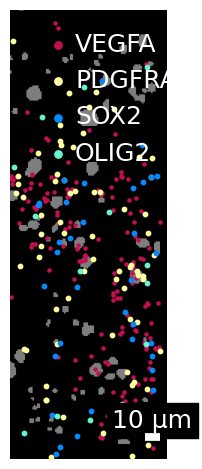

In [15]:
xlim=(6600, 6700)
ylim=(1000, 1300)

#xlim_rev = ()
#ylim_rev = ()

v =  [[xlim[0], ylim[0]],[xlim[1],ylim[1]]]

scale_factor = 1#0.27*4.5
img_zoom = img_SL023[int(v[0][1]*scale_factor):int(v[1][1]*scale_factor),int(v[0][0]*scale_factor):int(v[1][0]*scale_factor)]

sizes = [5, 10, 10, 10, 10] 

SL023.color_dict['VEGFA'] = mcolors.rgb2hex(palette['GW-like HYPR1'])
SL023.color_dict['FOXG1'] = mcolors.rgb2hex(gene_color['FOXG1'])
SL023.color_dict['SOX9'] = mcolors.rgb2hex(gene_color['SOX9'])
SL023.color_dict['SOX2'] = mcolors.rgb2hex(gene_color['SOX2'])
SL023.color_dict['NOTCH1'] = mcolors.rgb2hex(gene_color['NOTCH1'])
SL023.color_dict['OLIG1'] = mcolors.rgb2hex(gene_color['OLIG1'])
SL023.color_dict['OLIG2'] = mcolors.rgb2hex(gene_color['OLIG1'])
SL023.color_dict['PDGFRA'] = mcolors.rgb2hex(gene_color['PDGFRA'])
genes = ['VEGFA','PDGFRA','SOX2','OLIG2']

fig,ax = plt.subplots(1,1 ,figsize=(5,5))

SL023.scatter_plot(
    genes,
    s=sizes,
    ax_scale_factor=400,
    show_axes=False,
    show_legend=True,
    view = v,
    image=img_zoom,
    reset_xy=True,
    ax=ax,
    alpha_img=.5,
    save=True,
    save_name='figures/SL023_dots.svg'
)
